# Unsupervised learning

Zorg ervoor dat deze cellen vanboven naar beneden in het document uitgevoerd kunnen worden (Cell > Run All).
Laat je output staan om eenvoudig je antwoorden te kunnen controleren met je behaalde resultaten. 

Vergeet ook niet te antwoorden op de vragen over je oplossingen!

## Opgave 

De oefeningen in deze notebook focussen op de unsupervised learning technieken om clustering en dimensionality reduction uit te voeren.
Hiervoor wordt gebruik gemaakt van [deze dataset](https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv) die een reeks beelden van mensen met verschillend geslacht en ethniciteit bevat.
Voor elk beeld in deze dataset zijn drie labels toegevoegd, namelijk leeftijd, geslacht en ethniciteit.

Importeer alle benodigde packages hieronder en download deze dataset in de cell hieronder.
Merk op dat voor het inladen van de images zowel de os package en de cv2 package nodig zijn
Indien het cv2 package nog niet geinstalleerd is, kan het geinstalleerd worden met onderstaand commando:

In [3]:
#!pip install opencv-python

In [4]:
# alle imports hier
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import math
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
import pandas as pd
import random
import seaborn as sns

In [5]:
# download
od.download("https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv")

Skipping, found downloaded files in ".\age-gender-and-ethnicity-face-data-csv" (use force=True to force download)


Laad nu de dataset in in een dataframe en toon de kolommen die aanwezig zijn.

In [6]:
# inladen dataset
df = pd.read_csv("age-gender-and-ethnicity-face-data-csv/age_gender.csv")
display(df)
print(df.info())

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB
None


Merk op dat de kolom dat de pixels bevat het "object" datatype is. 
Dit komt omdat het een string bevat met een reeks getallen in. Schrijf hier nu een functie die de tekst van 1 figuur omzet naar een numpy matrix. 
De figuren in deze dataset zijn vierkantig dus de breedte en lengte is gelijk aan de vierkantswortel van het aantal pixels.
Ook is de figuur enkel grijswaarden dus kan je rechtstreeks de pixelwaarde gebruiken en heb je geen RGB waarde.
Daarnaast is het ook belangrijk voor het correct tekenen van de figuren om ervoor te zorgen dat het type van de numpy array integers bevat in plaats van strings.

In [7]:
# string to matrix function
def string_to_matrix(xd):
    width_and_length = int(math.sqrt(len(xd.split(" "))))

    list_of_words = xd.split(" ")

    matrix = np.zeros([width_and_length, width_and_length])

    for y in range(width_and_length):
        for x in range(width_and_length):
            matrix[y, x]  = list_of_words[(y*width_and_length)+x]
            
    return matrix.astype(int)

test = string_to_matrix((df["pixels"][0]))
print(test)

[[129 128 128 ... 118  99  53]
 [130 129 128 ... 117  98  52]
 [131 129 130 ... 114  97  50]
 ...
 [121 138 147 ... 151 150 148]
 [117 137 146 ... 149 148 148]
 [115 135 142 ... 146 146 146]]


Het is belangrijk op te merken dat de betekenis van de labels niet altijd eenduidig bepaald is. Toon daarom nu eerst een 5-tal willekeurige beelden met gender klasse 0 en 1. Wat is nu de betekenis van deze labels? Stelt label 0 een man of vrouw voor?

Drie willekeurige gender 0


,age,ethnicity,gender,img_name,pixels
22017,70,0,0,20170111210749134.jpg.chip.jpg,226 223 194 128 124 95 102 111 120 129 142 145...
15759,40,1,0,20170113152055344.jpg.chip.jpg,66 101 127 126 104 101 77 73 75 85 90 84 73 62...
3320,20,0,0,20170117141002911.jpg.chip.jpg,219 221 214 213 146 51 50 40 49 47 35 43 46 56...


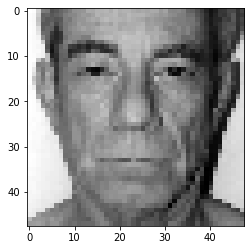

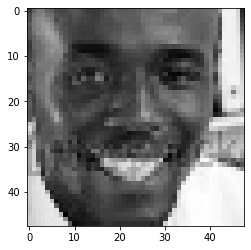

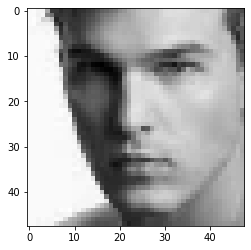

Drie willekeurige gender 1


,age,ethnicity,gender,img_name,pixels
10518,3,2,1,20161219160306229.jpg.chip.jpg,24 28 31 34 37 45 51 59 66 76 83 92 103 113 12...
10453,29,0,1,20170117174858696.jpg.chip.jpg,18 30 11 16 22 20 16 16 25 31 19 14 22 43 79 9...
6094,25,0,1,20170117140138784.jpg.chip.jpg,46 59 65 78 86 99 133 155 156 154 161 171 178 ...


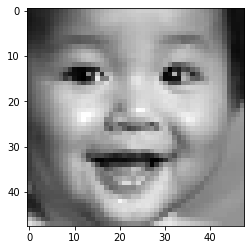

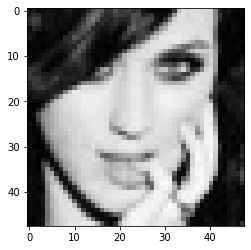

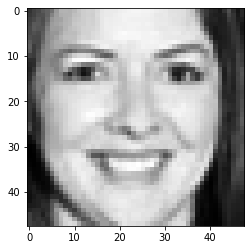

Conclusie: man = 0, vrouw = 1. Op de Kaggle pagina wordt er verwezen naar de bron -> op deze documentatie staat er ook man = 0, vrouw = 1. (https://susanqq.github.io/UTKFace/)


In [8]:
# show sample images for gender 0 en gender 1

for x in range(df["gender"].nunique()):
    selectie_gender = df[df["gender"] == x].sample(n = 3)

    print("Drie willekeurige gender " + str(x))
    display(selectie_gender)

    for index, row in selectie_gender.iterrows():
        plt.imshow(string_to_matrix((df["pixels"][index])), cmap='gray')
        plt.show()

print("Conclusie: man = 0, vrouw = 1. Op de Kaggle pagina wordt er verwezen naar de bron -> op deze documentatie staat er ook man = 0, vrouw = 1. (https://susanqq.github.io/UTKFace/)")

Doe dit ook voor de verschillende labels van etniciteit.
Welke ethniciteit komt overeen met welk label?
Indien het niet altijd snel duidelijk is, kan je het herhaaldelijk uitvoeren met andere figuren om een beter beeld te krijgen.

Drie willekeurige ethnicity 0


,age,ethnicity,gender,img_name,pixels
20209,58,0,0,20170117191847355.jpg.chip.jpg,165 173 187 163 139 140 157 173 192 198 202 20...
7499,26,0,0,20170113182141220.jpg.chip.jpg,13 16 32 68 106 133 145 149 157 163 165 168 16...
10152,29,0,0,20170109002204336.jpg.chip.jpg,57 52 66 83 89 98 124 147 163 171 175 180 183 ...


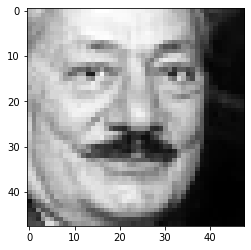

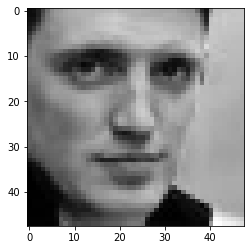

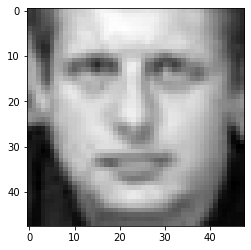

Drie willekeurige ethnicity 1


,age,ethnicity,gender,img_name,pixels
2566,18,1,0,20170113132627873.jpg.chip.jpg,169 180 156 50 47 59 74 92 106 107 109 115 117...
4130,22,1,1,20170105002015683.jpg.chip.jpg,40 56 43 75 69 25 21 41 61 60 55 85 84 78 77 1...
9627,28,1,1,20170103182939570.jpg.chip.jpg,7 6 4 6 11 9 26 62 82 93 106 120 129 134 141 1...


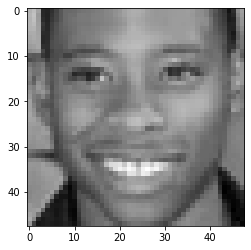

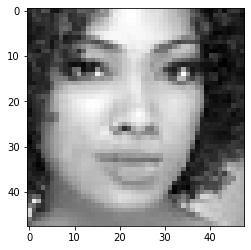

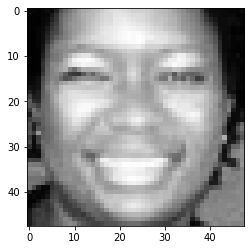

Drie willekeurige ethnicity 2


,age,ethnicity,gender,img_name,pixels
1019,1,2,1,20161219155811293.jpg.chip.jpg,5 14 24 41 55 59 67 74 74 87 79 85 87 87 89 73...
10093,29,2,0,20170116163503418.jpg.chip.jpg,52 47 69 66 56 59 83 100 88 72 90 85 89 91 109...
6379,26,2,1,20170116180404568.jpg.chip.jpg,29 56 106 114 119 131 152 160 166 174 175 177 ...


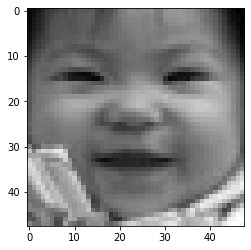

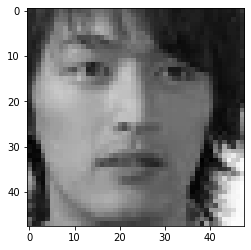

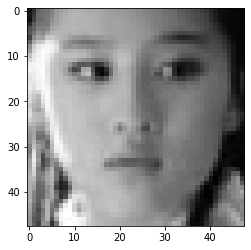

Drie willekeurige ethnicity 3


,age,ethnicity,gender,img_name,pixels
1225,10,3,1,20170104221711437.jpg.chip.jpg,144 144 146 144 150 148 117 40 29 24 24 22 33 ...
13026,34,3,0,20170119175413876.jpg.chip.jpg,151 64 57 72 96 113 124 129 130 131 135 138 14...
835,1,3,1,20161220144637487.jpg.chip.jpg,104 101 100 76 58 117 142 149 153 159 164 175 ...


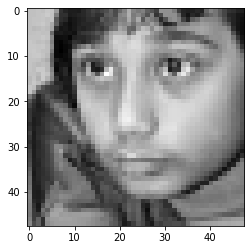

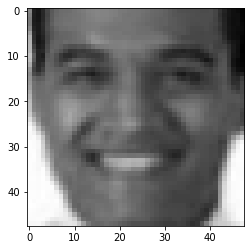

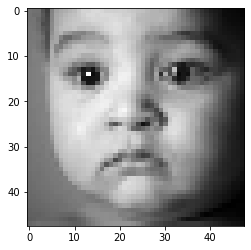

Drie willekeurige ethnicity 4


,age,ethnicity,gender,img_name,pixels
18433,51,4,1,20170103234622539.jpg.chip.jpg,107 108 70 81 108 82 87 122 116 111 123 120 14...
21834,7,4,1,20170103201832231.jpg.chip.jpg,185 148 49 30 23 66 86 103 109 132 148 154 160...
4789,24,4,1,20170103224843361.jpg.chip.jpg,3 5 16 17 10 12 20 29 15 5 1 2 8 28 63 90 104 ...


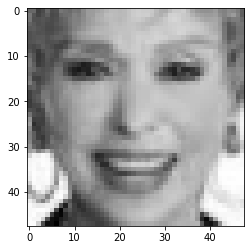

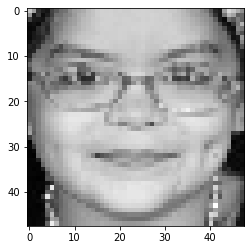

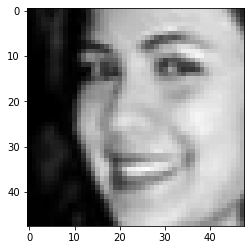

Conclusie: white = 0, black = 1, asian = 2, india = 3, en de rest = 4. Op de Kaggle pagina wordt er verwezen naar de bron -> op deze documentatie staat er ook white = 0, black = 1, asian = 2, india = 3, en de other = 4. (https://susanqq.github.io/UTKFace/)


In [9]:
# show sample images for different ethnicities

for x in range(df["ethnicity"].nunique()):
    selectie_ethnicity = df[df["ethnicity"] == x].sample(n = 3)

    print("Drie willekeurige ethnicity " + str(x))
    display(selectie_ethnicity)

    for index, row in selectie_ethnicity.iterrows():
        plt.imshow(string_to_matrix((df["pixels"][index])), cmap='gray')
        plt.show()

print("Conclusie: white = 0, black = 1, asian = 2, india = 3, en de rest = 4. Op de Kaggle pagina wordt er verwezen naar de bron -> op deze documentatie staat er ook white = 0, black = 1, asian = 2, india = 3, en de other = 4. (https://susanqq.github.io/UTKFace/)")

## Clustering

Gebruik nu K-Means clustering om de foto's te groeperen in clusters.
Let er hierbij op dat elke foto eerst moet omgezet worden naar een feature vector.
Gebruik ook enkel de pixelwaarden om de foto's te clusteren.

De belangrijkste hyperparameter in dit algoritme is de K of het aantal clusters. 
Ga op zoek naar de beste waarde voor deze parameter. 
Wat is de beste waarde en welke methode gebruik je om deze te bepalen. 
Geef voldoende informatie of visualisaties om je antwoord te verklaren.

In [10]:
# lege array aanmaken
data = []

# elke image omzetten naar 2d array en die in arraylist steken
for index, row in df.iterrows():
    tussenstap = np.fromstring(df["pixels"][index], dtype=int, sep=' ')
    data.append(tussenstap)

In [11]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=69)

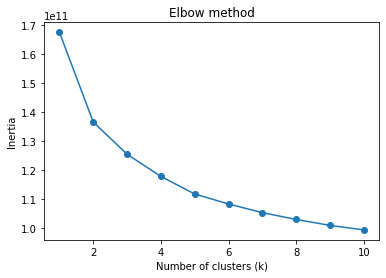

In [12]:
# find optimal value of K (Elbow method) 
k_range = range(1, 11)
inertias = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=69).fit(data)
    inertias.append(km.inertia_)

plt.plot(k_range, inertias, "-o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow method")
plt.show()

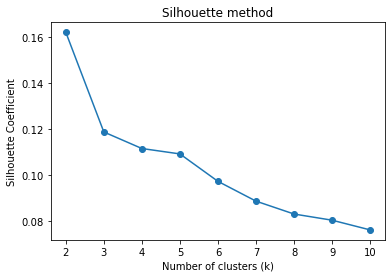

In [13]:
# find optimal value of K (Silhouette coefficient graph) 
k_range = range(2, 11)
silhouette_coefficients = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=69).fit(data)
    silhouette_coefficients.append(silhouette_score(data, kmeans.labels_))

plt.plot(k_range, silhouette_coefficients, "-o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Coefficient")
plt.title("Silhouette method")
plt.show()

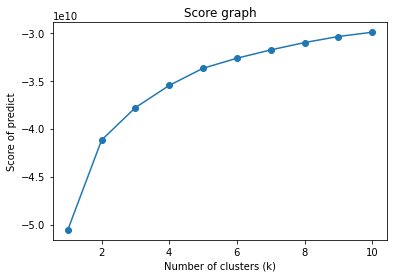

In [14]:
# score graph
k_range = range(1, 11)
scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=69).fit(X_train)
    scores.append(km.score(X_test))

plt.plot(k_range, scores, "-o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score of predict")
plt.title("Score graph")
plt.show()

**Antwoord:** 1) Ik heb gebruik gemaakt van de Elbow method. Best aantal clusters = 2. Je moet kijken naar het punt waar de WCSS opeens een pak minder daalt. Als je dan horizontale lijntjes trekt die door de punten gaan op de lijn van de grafiek zie je dat de daling sterk verminderd na x=2. 2) Ook heb ik een grafiek gemaakt van de silhouette coëfficiënt. Waar deze het hoogste is, is K de beste. Dit is op plek 2 en bewijst dus ook mijn vorig antwoord dat k=2 de beste is. 3) Dan heb ik een grafiek gemaakt met de scores van de predict. Hier zie je dat de score veel minder snel stijgt na k=2. Ik denk dat het dus wel zeker is dat 2 clusters de beste hoeveelheid is voor dit scenario. Het zou bijvoorbeeld ook kunnen te maken hebben met iets van informatie dat we al hebben zoals geslacht is oftewel man oftewel vrouw (=2 mogelijkheden) maar dit weten we nog niet zeker en bekijk ik in de volgende vraag.

Train nu een clustering model met het K-means algoritme en je zelf gekozen aantal clusters. 
Print voor elke cluster een sample van 5 foto's.

Test data + predicted cluster


,pixels,cluster
0,149 149 149 149 149 149 150 151 151 151 149 14...,1
1,151 157 159 169 166 158 149 149 148 146 144 14...,0
2,7 3 6 6 5 6 8 12 17 21 23 26 24 19 19 13 12 17...,0
3,63 80 90 130 173 184 194 199 206 213 213 218 2...,0
4,77 104 96 33 150 155 177 184 179 174 174 165 1...,0
...,...,...
7107,53 53 53 73 63 40 28 33 25 35 48 51 52 93 144 ...,1
7108,16 11 22 36 47 61 71 90 106 117 123 132 136 14...,1
7109,231 181 179 192 200 197 195 191 189 191 194 19...,0
7110,172 168 167 122 39 40 76 80 82 84 90 94 96 97 ...,1


5 Willekeurige foto's van cluster = 0


,age,ethnicity,gender,img_name,pixels
10518,3,2,1,20161219160306229.jpg.chip.jpg,24 28 31 34 37 45 51 59 66 76 83 92 103 113 12...
10453,29,0,1,20170117174858696.jpg.chip.jpg,18 30 11 16 22 20 16 16 25 31 19 14 22 43 79 9...
6094,25,0,1,20170117140138784.jpg.chip.jpg,46 59 65 78 86 99 133 155 156 154 161 171 178 ...


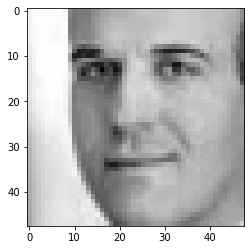

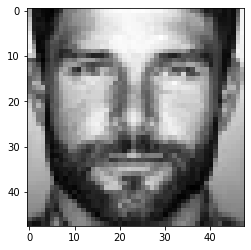

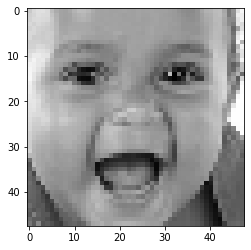

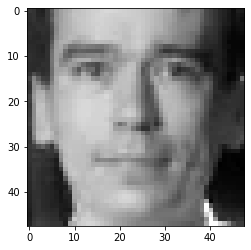

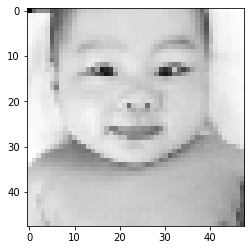

5 Willekeurige foto's van cluster = 1


,age,ethnicity,gender,img_name,pixels
10518,3,2,1,20161219160306229.jpg.chip.jpg,24 28 31 34 37 45 51 59 66 76 83 92 103 113 12...
10453,29,0,1,20170117174858696.jpg.chip.jpg,18 30 11 16 22 20 16 16 25 31 19 14 22 43 79 9...
6094,25,0,1,20170117140138784.jpg.chip.jpg,46 59 65 78 86 99 133 155 156 154 161 171 178 ...


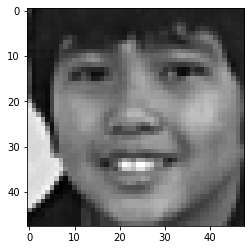

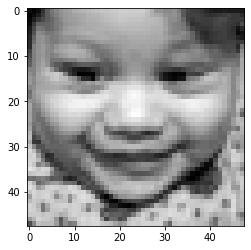

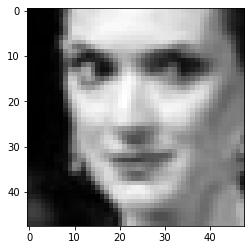

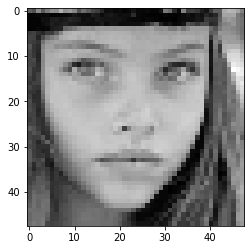

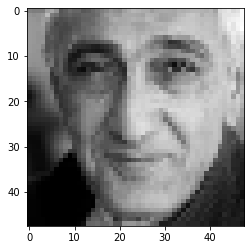

In [15]:
clusteramount = 2
model = KMeans(n_clusters = clusteramount, random_state = 50)

model.fit(X_train)
prediction = model.predict(X_test)

pixelstringsfix = []
for i in X_test:
    string = ""
    for i in i:
        string += str(i) + " "
    pixelstringsfix.append(string)

df_example = pd.DataFrame(columns=["pixels"], data=pixelstringsfix)
df_example["cluster"] = prediction

print("Test data + predicted cluster")
display(df_example)

for i in range(clusteramount):
    selectie_cluster = df_example[df_example["cluster"] == i].sample(n = 5)

    print("5 Willekeurige foto's van cluster = " + str(i))
    display(selectie_gender)

    for index, row in selectie_cluster.iterrows():
        plt.imshow(string_to_matrix((df_example["pixels"][index])), cmap='gray')
        plt.show()

**Kun je zien welke factoren gemeenschappelijk zijn in de clusters/waarop er vooral geclusterd wordt?
Het kan zijn dat dit niet eenvoudig te zien is maar doe een goede gok.**

**Antwoord:** Ik denk dat hij clustert op soort van helderheid. Als je het een paar keer uitvoert valt het op dat het bij cluster 1 over het algemeen veel meer donkere pixels voorkomen dan bij cluster 0.

Indien je grote K waarden geprobeerd hebt bij het kiezen van het aantal clusters heb je gemerkt dat de rekentijd van het KMeans clustering algoritme vrij snel sterk kan oplopen.
Om het algoritme te versnellen kunnen we het aantal features beperken. 
Gebruik Principal Component Analysis om dit te doen.
Hoeveel features zijn er nodig om ongeveer 80% van de informatie over te houden?
Hoeveel heb je er nodig om 90% van de informatie over te houden?
Toon hiervoor ook een plot om je antwoord te staven.

**Antwoord:** 
Conclusie: 19 is het best passende getal voor aantal componenten om 80% van de informatie te behouden
Conclusie: 65 is het best passende getal voor aantal componenten om 90% van de informatie te behouden

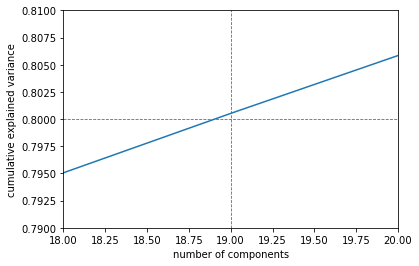

In [16]:
# ingezoomde figuur voor te kijken hoeveel compoenten ik nodig heb voor 80% van de informatie over te houden
fig, ax = plt.subplots()

pca = PCA().fit(data)
ax.plot(np.cumsum(pca.explained_variance_ratio_))

ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance');
ax.axhline(y=0.8, ls="--", lw=0.8)
ax.axvline(x=19, ls="--", lw=0.8)

ax.set_xlim(18, 20)
ax.set_ylim(0.79, 0.81)

plt.show()

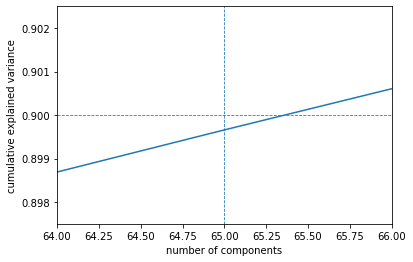

In [17]:
# ingezoomde figuur voor te kijken hoeveel compoenten ik nodig heb voor 90% van de informatie over te houden
fig, ax = plt.subplots()

pca = PCA().fit(data)
ax.plot(np.cumsum(pca.explained_variance_ratio_))

ax.set_xlabel('number of components')
ax.set_ylabel('cumulative explained variance');
ax.axhline(y=0.9, ls="--", lw=0.8)
ax.axvline(x=65, ls="--", lw=0.8)

ax.set_xlim(64, 66)
ax.set_ylim(0.8975, 0.9025)

plt.show()

In [18]:
def plot_pca_components(x, coefficients=None, mean=0, components=None,
                        imshape=(48, 48), n_components=65, fontsize=12,
                        show_mean=True):
    # validatie/fouten voorkomen
    if coefficients is None:
        coefficients = x
        
    if components is None:
        components = np.eye(len(coefficients), len(x))
        
    mean = np.zeros_like(x) + mean
        
    # maakt de figuur aan (Grid is 2 rijen + 13 kolommen) (4 is om de eerste en laatste figuur 2 kolommen elk te laten innemen)
    fig = plt.figure(figsize=(1.2 * (5 + n_components), 1.2 * 2))
    g = plt.GridSpec(2, 4 + bool(show_mean) + n_components, hspace=0.3)

    # feature vector to image en plot
    def show(i, j, x, title=None):
        ax = fig.add_subplot(g[i, j], xticks=[], yticks=[])
        # imshow om figuur/matrix te tonen
        ax.imshow(x.reshape(imshape), interpolation='nearest')
        if title:
            ax.set_title(title, fontsize=fontsize)

    show(slice(2), slice(2), x, "True")
    
    approx = mean.copy()
    
    counter = 2
    if show_mean:
        show(0, 2, np.zeros_like(x) + mean, r'$\mu$')
        show(1, 2, approx, r'$1 \cdot \mu$')
        counter += 1

    for i in range(n_components):
        # teken de componenten een voor 1
        approx = approx + coefficients[i] * components[i]
        # teken de bovenste rij
        show(0, i + counter, components[i], r'$c_{0}$'.format(i + 1))
        # teken de onderste rij
        show(1, i + counter, approx,
             r"${0:.2f} \cdot c_{1}$".format(coefficients[i], i + 1))
        if show_mean or i > 0:
            plt.gca().text(0, 1.05, '$+$', ha='right', va='bottom',
                           transform=plt.gca().transAxes, fontsize=fontsize)

    show(slice(2), slice(-2, None), approx, "Approx")
    return fig

Teken nu de volgende twee figuren naast elkaar:
* Een willekeurige figuur uit de dataset
* Het resultaat na PCA met het aantal features dat je hierboven gekozen hebt om 90% van de informatie te behouden.

Wat valt er je op bij het vergelijken van de twee figuren? Bekijk ook hoeveel waarden er nodig zijn voor beide figuren op te slaan. Wat is het verschil in aantal features voor beide figuren?

**Antwoord:** De ene figuur ziet er wat meer geblurt uit. De overgang tussen pixels is 'smoother'. Voor pca heb je 2304 waarden, na pca nog maar 65.

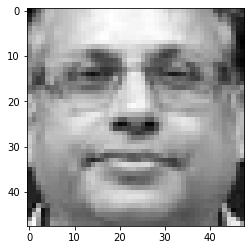

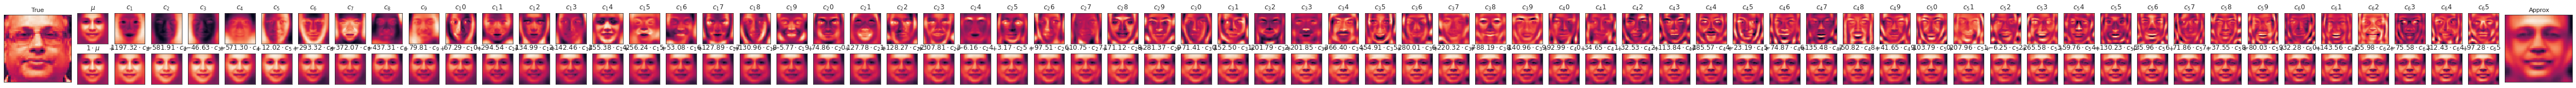

In [19]:
#random generator
index = random.randint(0, len(data))

#originele img
string = ""
for i in data[index]:
    string += str(i) + " "

plt.imshow(string_to_matrix(string), cmap='gray')
plt.show()

# pca fit transform en plot components
pca = PCA(n_components=65)
Xproj = pca.fit_transform(data)
sns.set_style('white')
fig = plot_pca_components(data[index], Xproj[index], pca.mean_, pca.components_)

Ga nu opnieuw opzoek naar het ideale aantal clusters aanwezig in de dataset maar gebruik hiervoor de gereduceerde features.
Is het aantal clusters veranderd? Hoe zou dit kunnen komen?
Print opnieuw ook per cluster eens een sample uit van 5 personen.
Is het nu eenvoudiger om gelijkenissen te herkennen tussen figuren van dezelfde clusters?

**Antwoord:** Ideale clusters is nog altijd twee. De drie grafieken die ik heb opgesteld zien er zo goed als hetzelfde uit voor of na PCA. Dit is logisch want je behoudt 90% van de data dus de grafieken zouden zogezegd 90% moeten lijken op die voor PCA. Het is me niet gelukt om de images na pca te tonen bij specifieke cluster maar als ik de pca components plot dan zie je wel dat het nog altijd gaat over een onderscheid tussen donker en licht. Dus ik vermoed dat het nog altijd over zo goed als dezelfde clusters gaan.

In [20]:
X1_train, X1_test = train_test_split(Xproj, test_size=0.3, random_state=69)

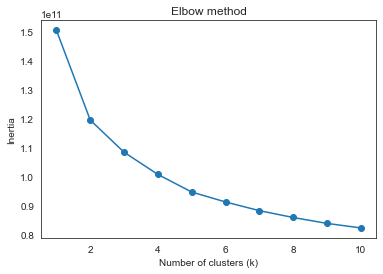

In [21]:
# find optimal value of K (Elbow method) 
k_range = range(1, 11)
inertias = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=69).fit(Xproj)
    inertias.append(km.inertia_)

plt.plot(k_range, inertias, "-o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow method")
plt.show()

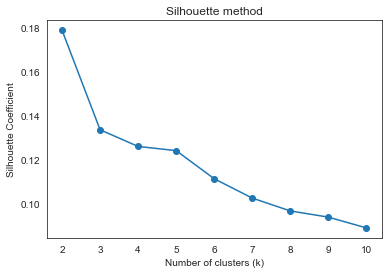

In [22]:
# find optimal value of K (Silhouette coefficient graph) 
k_range = range(2, 11)
silhouette_coefficients = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=69).fit(Xproj)
    silhouette_coefficients.append(silhouette_score(Xproj, kmeans.labels_))

plt.plot(k_range, silhouette_coefficients, "-o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Coefficient")
plt.title("Silhouette method")
plt.show()

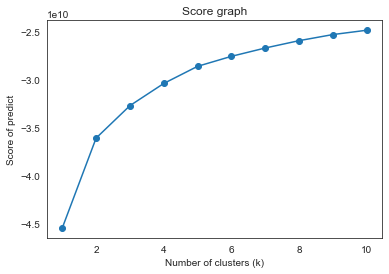

In [23]:
# score graph
k_range = range(1, 11)
scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=69).fit(X1_train)
    scores.append(km.score(X1_test))

plt.plot(k_range, scores, "-o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Score of predict")
plt.title("Score graph")
plt.show()

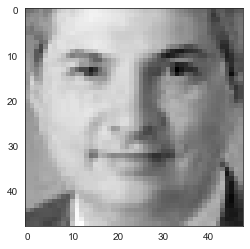

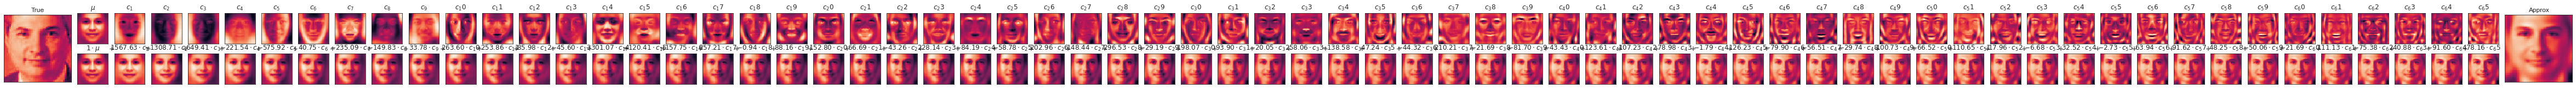

In [24]:
#random generator
index = random.randint(0, len(data))

#originele img
string = ""
for i in data[index]:
    string += str(i) + " "

plt.imshow(string_to_matrix(string), cmap='gray')
plt.show()

# pca fit transform en plot components
pca = PCA(n_components=65)
Xproj = pca.fit_transform(data)
sns.set_style('white')
fig = plot_pca_components(data[index], Xproj[index], pca.mean_, pca.components_)

Test data + predicted cluster


,pca components,cluster
0,-971.8469570653035 -622.2573053919069 1469.853...,0
1,1363.0795773433597 2764.790296793096 93.867675...,1
2,540.8748712581794 -543.8371878892154 47.493770...,1
3,2527.0406347084468 -483.9356760431686 -1311.46...,1
4,2003.5824292877767 -1313.8651687762788 540.549...,1
...,...,...
7107,-1194.0741297993327 -1010.9084299973181 -788.4...,0
7108,-478.6060918725963 -1319.040167554724 -668.038...,0
7109,2016.4851040331257 -203.31311652096608 -638.36...,1
7110,-1297.0138538108313 1150.1943860816175 238.738...,0


5 Willekeurige foto's van cluster = 0


,age,ethnicity,gender,img_name,pixels
10518,3,2,1,20161219160306229.jpg.chip.jpg,24 28 31 34 37 45 51 59 66 76 83 92 103 113 12...
10453,29,0,1,20170117174858696.jpg.chip.jpg,18 30 11 16 22 20 16 16 25 31 19 14 22 43 79 9...
6094,25,0,1,20170117140138784.jpg.chip.jpg,46 59 65 78 86 99 133 155 156 154 161 171 178 ...


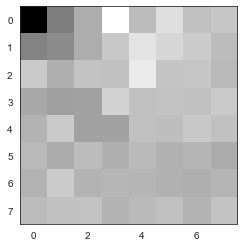

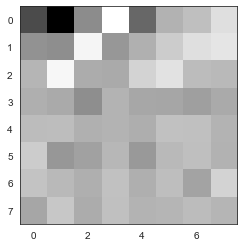

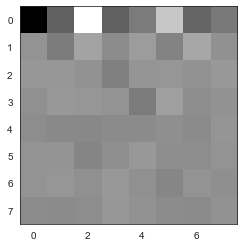

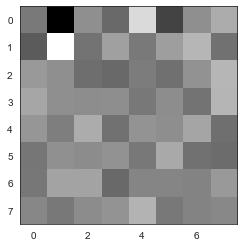

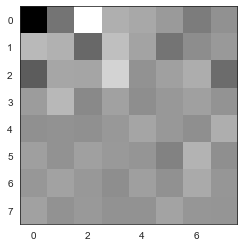

5 Willekeurige foto's van cluster = 1


,age,ethnicity,gender,img_name,pixels
10518,3,2,1,20161219160306229.jpg.chip.jpg,24 28 31 34 37 45 51 59 66 76 83 92 103 113 12...
10453,29,0,1,20170117174858696.jpg.chip.jpg,18 30 11 16 22 20 16 16 25 31 19 14 22 43 79 9...
6094,25,0,1,20170117140138784.jpg.chip.jpg,46 59 65 78 86 99 133 155 156 154 161 171 178 ...


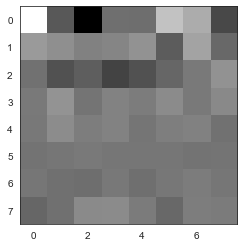

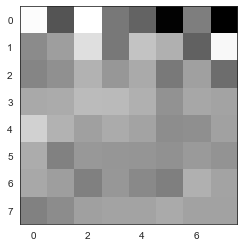

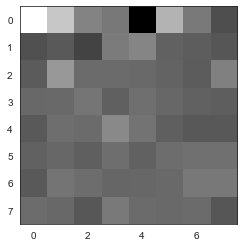

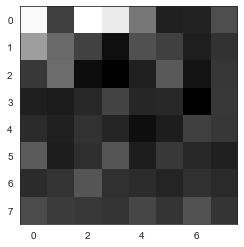

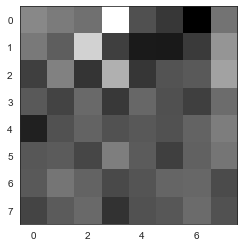

In [28]:
clusteramount = 2
model = KMeans(n_clusters = clusteramount, random_state = 50)

model.fit(X1_train)
prediction = model.predict(X1_test)

pixelstringsfix = []
for i in X1_test:
    string = ""
    for i in i:
        string += str(i) + " "
    pixelstringsfix.append(string)

df_example = pd.DataFrame(columns=["pca components"], data=pixelstringsfix)
df_example["cluster"] = prediction

print("Test data + predicted cluster")
display(df_example)

for i in range(clusteramount):
    selectie_cluster = df_example[df_example["cluster"] == i].sample(n = 5)

    print("5 Willekeurige foto's van cluster = " + str(i))
    display(selectie_gender)

    for index, row in selectie_cluster.iterrows():
        plt.imshow(string_to_matrix((df_example["pca components"][index])), cmap='gray')
        plt.show()